#### outlook collecting data

In [ ]:
import json
with open('outlook_mapi.json') as ol_guide:
    guide = json.load(ol_guide)

for k, v in guide.items():
    if k.lower().count('type'):
        print(f'{k}: {v}\n')

In [ ]:
from win32com import client
import pandas as pd
pd.set_option('display.max_colwidth', 0)

ol = client.Dispatch('Outlook.Application').GetNamespace("MAPI")
inbox = ol.Folders['yourEmail@domain.zone'].Folders['Входящие']
messages = list(inbox.Items)

messages_list = []
for m in messages:
    if m.Class != 43:
        continue
    message_dict = {}
    message_dict['EntryID'] = str(getattr(m, 'EntryID', '<NULL>'))
    message_dict['create_date'] = str(getattr(m, 'SentOn', '<NULL>'))[:10]
    message_dict['Subject'] = str(getattr(m, 'Subject', '<NULL>'))
    message_dict['Sender'] = str(getattr(m, 'Sender', '<NULL>'))
    message_dict['MsgSize'] = round(int(getattr(m, 'EntryID', '<NULL>')) / 1024**2, 3)
    message_dict['att_cnt'] = len(list(getattr(m, 'Attachments', '')))
    
    if message_dict['att_cnt']:
        for a in list(m.Attachments):
            message_dict['filename'] = str(getattr(a, 'filename', '<NULL>'))
            message_dict['mb'] = round(int(getattr(a, 'size', 0)) / 1024, 3)
            messages_list.append(message_dict.copy())
    else:
        message_dict['filename'] = ''
        message_dict['mb'] = 0
        messages_list.append(message_dict.copy())
    messages_list.append(message_dict)
print(len(messages_list))
         
df_ol = pd.DataFrame.from_dict(messages_list)    
df_ol[df_ol.columns[1:]].head(3)

#### filesystem collecting data

In [68]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)

from datetime import datetime as dt
import os
from os.path import join, getsize, getctime, getmtime, getatime
fs = []
for root, dirs, files in os.walk('/Users/af13/Documents/p'):
    for f in files:
        fs.append(join(root, f))

df_fs = pd.DataFrame(fs, columns=['filename'])

def get_size(x):
    try:
        return round(getsize(x) / 1024**2, 3)
    except OSError:
        return -1
    
def get_ctime(x):
    try:
        return dt.strftime(dt.fromtimestamp(getctime(x)), '%Y-%m-%d')
    except OSError:
        return -1
    
def get_mtime(x):
    try:
        return dt.strftime(dt.fromtimestamp(getmtime(x)), '%Y-%m-%d')
    except OSError:
        return -1

df_fs['create_date'] = df_fs.filename.apply(get_ctime)
df_fs['modified_date'] = df_fs.filename.apply(get_mtime)
df_fs['mb'] = df_fs.filename.apply(get_size)
df_fs = df_fs[df_fs.mb > -1]

In [95]:
SAFE_EXTENSIONS = ('csv', 'tsv', 'xlsx', 'xls', 'jpg', 'png', 'mp3', 'mp4', 'wav', 'mov', 'pdf')
OFFSET_BEYOND_DELETE = 4
DDOF0 = -25
DDOF1 = -100
DDOF2 = -300

from scipy import stats
from matplotlib import pyplot as plt
from IPython.display import HTML, display
plt.rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (2.3, 3)

def find_outliers(df0: pd.DataFrame) -> pd.DataFrame:
    def get_extension(path: str) -> str:
        f_name = path[::-1].split(os.sep)[0][::-1]
        return f_name[::-1].split('.')[0][::-1]
    
    x = df0.copy()
    x['ext'] = x.filename.apply(get_extension)
    x['safe_ext'] = x.ext.isin(SAFE_EXTENSIONS)
    x.sort_values('mb', ascending=False, inplace=True)
    
    x['mb_sum'] = x[['ext', 'mb']].groupby(['ext']).mb.transform(sum)
    x['ext_count'] = x[['ext', 'mb']].groupby(['ext']).mb.transform('count')
    x.sort_values(['ext', 'mb'], ascending=[True, False], inplace=True)
    x['mb_cumsum'] = x[['ext', 'mb']].groupby(['ext']).mb.transform('cumsum')
    x['i'] = 1
    x['i'] = x[['ext', 'i']].groupby(['ext']).i.transform('cumsum')
    x['mb_cumsum_fr'] = round(x.mb_cumsum / x.mb_sum, 2)
    x['i_fr'] = round(x.i / x.ext_count, 2)

    x['z0'] = round(x[['ext', 'mb']].groupby(['ext']).mb.transform(lambda _: stats.zscore(_, ddof=DDOF0)), 2)
    x['z1'] = round(x[['ext', 'mb']].groupby(['ext']).mb.transform(lambda _: stats.zscore(_, ddof=DDOF1)), 2)
    x['z2'] = round(x[['ext', 'mb']].groupby(['ext']).mb.transform(lambda _: stats.zscore(_, ddof=DDOF2)), 2)
    
    x.z0 = x.z0.fillna(-1)
    x.z1 = x.z1.fillna(-1)
    x.z2 = x.z2.fillna(-1)
    
    x['z_ALERT'] = x.z0.apply(lambda _: False if _ < 3 else True)
    x['z_DETECTED'] = x[['ext', 'z_ALERT']].groupby(['ext']).z_ALERT.transform(max).astype(bool)
    
    x['cutoff_with_offset'] = x[['ext', 'z_ALERT', 'i']][x.z_ALERT].groupby(['ext', 'z_ALERT']).i.transform(max) + OFFSET_BEYOND_DELETE
    x.cutoff_with_offset = x[['ext', 'cutoff_with_offset']].groupby(['ext']).cutoff_with_offset.transform(max)
    x.cutoff_with_offset.fillna(-1, inplace=True)
    x.cutoff_with_offset = x.cutoff_with_offset.astype(int)
    x.mb = (x.mb - 1) // 1 + 1
    x.mb_sum = round(x.mb_sum)
    x = x.astype({'mb': int, 'mb_sum': int})
    return x

def plot_outliers(df0: pd.DataFrame):
    df = df0.copy()
    df['delete?'] = df.z_ALERT
    ext = df.ext.iloc[0]
    if ext == '':
        ext = 'noEXT'
    p = df.mb.value_counts()
    colors = []
    for _ in p.index:
        if _ in df[df.z_ALERT].mb.tolist():
            colors.append('red')
        else:
            colors.append('green')
    
    plt.scatter(p, p.index, marker='.', c=colors)
    plt.xlabel('extension frequency')
    plt.ylabel('extension size, Mb')
    plt.legend(f'{ext}    {p.sum()} files', markerscale=0, fontsize=6)
    outliers_count = len(df[df.z_ALERT])
    outliers_mb = df[df.z_ALERT].mb.sum()
    total_count = len(df)
    total_mb = df.mb_sum.iloc[0]
    if df.safe_ext.iloc[0]:
        safe_ext_span_tag = '<span style="margin-left:10px; font-size:11px; color:#6a8046;">safe ext</span>'
    else:
        safe_ext_span_tag = '<span style="margin-left:10px; font-size:11px; color:#8a653f;">unknown ext</span>'
    
    display(HTML(f'''<hr>
    <h4>Extension ".{ext}" {safe_ext_span_tag}
    <br>&nbsp;&nbsp;&nbsp;&nbsp;outliers: <span style="color:red;">{outliers_count}</span>
    of <span style="color:#777">{total_count}</span>
    <span style="margin-left:10px;">
        <small style="color:red;">{outliers_mb} Mb</small>
    of 
        <small style="color:#555;">{total_mb} Mb</small></span>
    </h4>'''))
    columns = ['mb', 'z0', 'z1', 'z2', 'filename', 'create_date', 'modified_date', 'delete?']
    if not 'modified_date' in df.columns:
        columns.remove('modified_date')
    display(df[df.i <= df.cutoff_with_offset][columns])
    plt.show()
    
    


,mb,z0,z1,z2,filename,create_date,modified_date,delete?
67414,70,26.84,27.78,30.15,/Users/af13/Documents/p/fitness/c.mp4,2020-08-29,2019-09-01,True
3267,12,4.09,4.23,4.59,/Users/af13/Documents/p/9gag/9gags_20201010_223401/296_ Old but gold.mp4,2020-10-10,2020-10-10,True
3121,11,3.76,3.89,4.22,/Users/af13/Documents/p/9gag/9gags_20201010_223401/143_ This deserves to be here.mp4,2020-10-10,2020-10-10,True
3117,10,3.54,3.67,3.98,/Users/af13/Documents/p/9gag/9gags_20201010_223401/268_ Real Heroes.mp4,2020-10-10,2020-10-10,True
1007,10,3.38,3.50,3.80,/Users/af13/Documents/p/9gag/9gags_20201011_024611_telegram_comments/033_ Nostalgic music and people being humans really can make you smile.mp4,2020-10-11,2020-10-11,True
3472,10,3.32,3.43,3.72,/Users/af13/Documents/p/9gag/9gags_20201010_223401/336_ The ads are getting smarter (cool figure effects).mp4,2020-10-10,2020-10-10,True
3410,10,3.30,3.42,3.71,/Users/af13/Documents/p/9gag/9gags_20201010_223401/010_ Human species documentary.mp4,2020-10-10,2020-10-10,True
3296,9,3.16,3.27,3.55,/Users/af13/Documents/p/9gag/9gags_20201010_223401/276_ Real recognizes real.mp4,2020-10-10,2020-10-10,True
3380,9,2.95,3.05,3.31,/Users/af13/Documents/p/9gag/9gags_20201010_223401/319_ Just came across this.mp4,2020-10-10,2020-10-10,False
3340,9,2.88,2.98,3.23,/Users/af13/Documents/p/9gag/9gags_20201010_223401/252_ She has an awesome personality.mp4,2020-10-10,2020-10-10,False


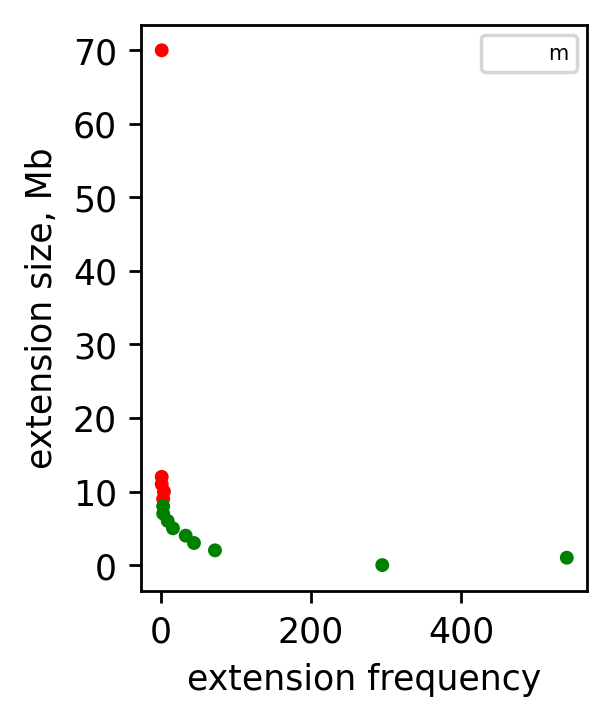

,mb,z0,z1,z2,filename,create_date,modified_date,delete?
67403,524,4.01,6.91,11.51,/Users/af13/Documents/p/=michael_gleissner_youtube_api/backstage/postgres/db.sql,2021-01-01,2020-08-29,True
18604,524,4.01,6.91,11.51,/Users/af13/Documents/p/yt_gnosis/backstage/postgres/db.sql,2020-09-15,2020-09-15,True
3536,0,-0.73,-1.26,-2.09,/Users/af13/Documents/p/yt_gnosis/yt_gnosis/yt_gnosis/postgresql_create_exp_views.sql,2020-12-10,2020-12-10,False
44056,0,-0.73,-1.26,-2.09,/Users/af13/Documents/p/=michael_gleissner_youtube_api/yt/linkeater/core_lib/postgresql_create_export_views.sql,2020-09-19,2020-09-07,False
3678,0,-0.73,-1.26,-2.09,/Users/af13/Documents/p/yt_gnosis/yt_gnosis/dm/static/sql_scripts/video_comments_by_tremester.sql,2020-12-15,2020-12-15,False
67387,0,-0.73,-1.26,-2.09,/Users/af13/Documents/p/=michael_gleissner_youtube_api/backstage/0=michael/postgresql_create_table.sql,2020-09-15,2020-06-15,False


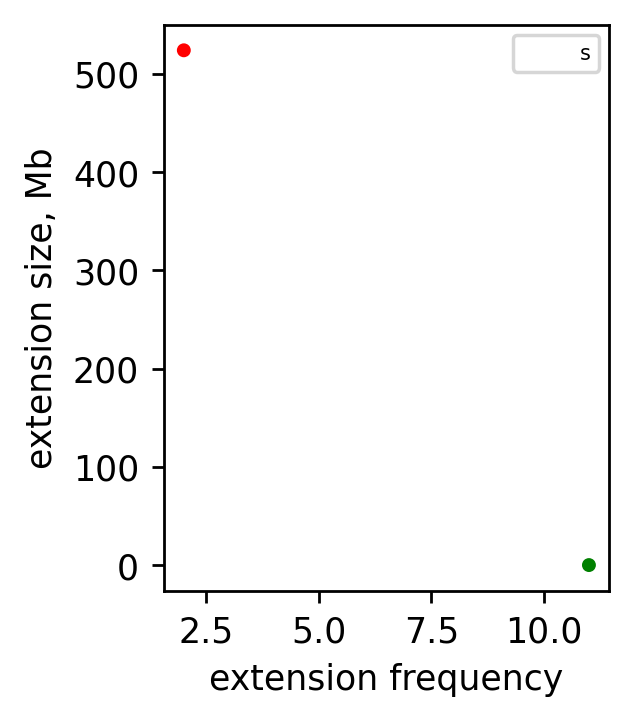

,mb,z0,z1,z2,filename,create_date,modified_date,delete?
41337,61,4.39,5.59,7.94,/Users/af13/Documents/p/dino/venv/lib/python3.8/site-packages/numpy/.dylibs/libopenblas.0.dylib,2021-03-03,2021-03-03,True
46468,60,4.32,5.49,7.81,/Users/af13/Documents/p/=michael_gleissner_youtube_api/venv/lib/python3.8/site-packages/numpy/.dylibs/libopenblasp-r0.3.7.dylib,2020-08-27,2020-06-12,True
58038,60,4.30,5.48,7.79,/Users/af13/Documents/p/=michael_gleissner_youtube_api/15venv/lib/python3.8/site-packages/numpy/.dylibs/libopenblas.0.dylib,2020-09-14,2020-09-13,True
20421,60,4.30,5.48,7.79,/Users/af13/Documents/p/rh/venv/lib/python3.8/site-packages/numpy/.dylibs/libopenblas.0.dylib,2020-09-22,2020-09-22,True
46472,60,4.30,5.48,7.79,/Users/af13/Documents/p/=michael_gleissner_youtube_api/venv/lib/python3.8/site-packages/numpy/.dylibs/libopenblas.0.dylib,2020-09-12,2020-09-12,True
7457,60,4.30,5.48,7.79,/Users/af13/Documents/p/yt_gnosis/venv/lib/python3.8/site-packages/numpy/.dylibs/libopenblas.0.dylib,2020-09-27,2020-09-27,True
40413,16,0.86,1.10,1.56,/Users/af13/Documents/p/dino/venv/lib/python3.8/site-packages/cv2/.dylibs/libavcodec.58.54.100.dylib,2021-03-03,2021-03-03,False
40431,2,-0.17,-0.22,-0.31,/Users/af13/Documents/p/dino/venv/lib/python3.8/site-packages/cv2/.dylibs/libcrypto.1.1.dylib,2021-03-03,2021-03-03,False
60770,2,-0.18,-0.23,-0.32,/Users/af13/Documents/p/=michael_gleissner_youtube_api/15venv/lib/python3.8/site-packages/psycopg2/.dylibs/libcrypto.1.1.dylib,2020-09-14,2020-09-13,False
11498,2,-0.18,-0.23,-0.32,/Users/af13/Documents/p/yt_gnosis/venv/lib/python3.8/site-packages/psycopg2/.dylibs/libcrypto.1.1.dylib,2020-09-27,2020-09-27,False


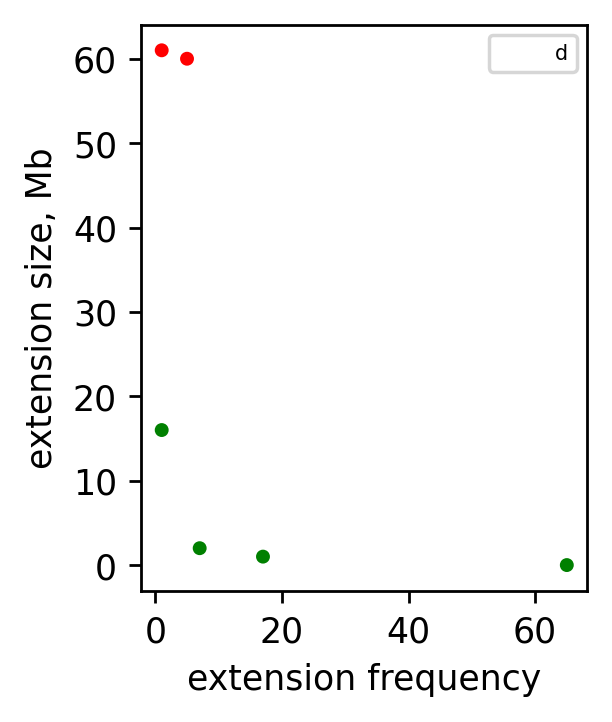

,mb,z0,z1,z2,filename,create_date,modified_date,delete?
40400,62,20.93,22.56,26.42,/Users/af13/Documents/p/dino/venv/lib/python3.8/site-packages/cv2/cv2.cpython-38-darwin.so,2021-03-03,2021-03-03,True
41050,5,1.39,1.50,1.75,/Users/af13/Documents/p/dino/venv/lib/python3.8/site-packages/numpy/core/_multiarray_umath.cpython-38-darwin.so,2021-03-03,2021-03-03,False
30956,4,1.37,1.48,1.73,/Users/af13/Documents/p/neto/venv/lib/python3.8/site-packages/cryptography/hazmat/bindings/_openssl.abi3.so,2020-09-23,2020-09-23,False
7276,4,1.35,1.45,1.70,/Users/af13/Documents/p/yt_gnosis/venv/lib/python3.8/site-packages/numpy/core/_multiarray_umath.cpython-38-darwin.so,2020-09-27,2020-09-27,False
20158,4,1.35,1.45,1.70,/Users/af13/Documents/p/rh/venv/lib/python3.8/site-packages/numpy/core/_multiarray_umath.cpython-38-darwin.so,2020-09-22,2020-09-22,False


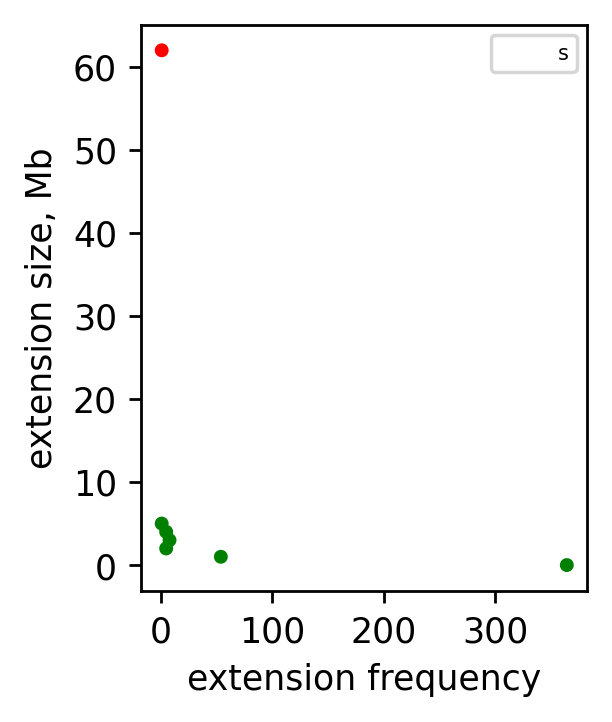

,mb,z0,z1,z2,filename,create_date,modified_date,delete?
29694,74,4.22,8.09,13.87,/Users/af13/Documents/p/rh/.git/objects/pack/pack-5207a1da1c153976fab3f83c35df636e77dfff32.pack,2020-09-22,2020-09-22,True
39991,23,-1.29,-2.48,-4.25,/Users/af13/Documents/p/neto/venv/src/oauth2client/.git/objects/pack/pack-75fe743cc3ce1d04a36839078eac5a73cb8f1e9a.pack,2020-09-23,2020-09-23,False
67642,8,-2.92,-5.61,-9.62,/Users/af13/Documents/p/tmp/YouTube_Analyzer/.git/objects/pack/pack-a94374f2050a69b22c2fb96a3b08e3fa733c0ccd.pack,2020-09-17,2020-09-17,False


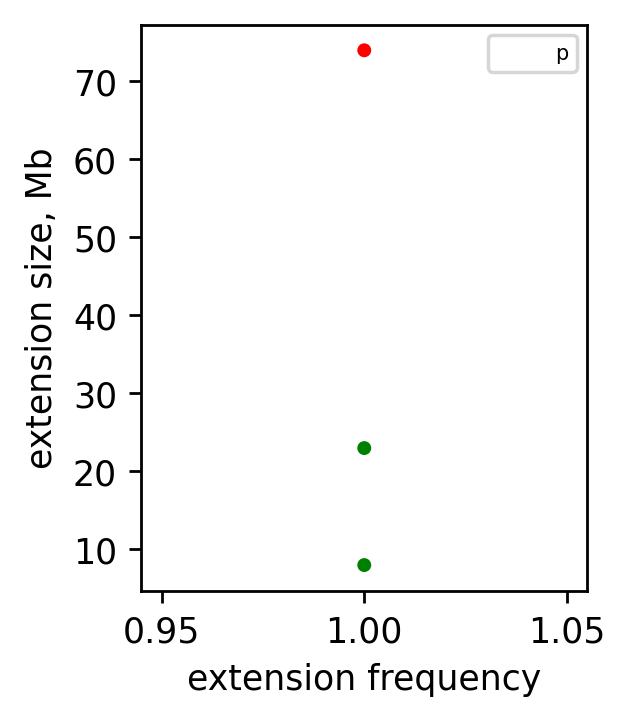

In [96]:
x = find_outliers(df_fs)
for ext in x[x.z_DETECTED & (x.mb>10)][['ext', 'safe_ext', 'mb_sum']].drop_duplicates().sort_values(['safe_ext', 'mb_sum'], ascending=[False, False]).ext:
    plot_outliers(x[x.ext==ext])